In [1]:
import collections
import fasttext
import gzip
import json
import math
import matplotlib
import nltk
import os
import pickle
import pyLDAvis
import random
import scipy.sparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from joblib import dump, load
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import LongType, StructField, StructType
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import Vectors, SparseVector
from scipy.sparse import dok_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

nltk.download('stopwords')

/home/olam/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
conf = SparkConf().setMaster("local[4]").setAll([
    ('spark.executor.memory', '8g'),
    ('spark.driver.memory', '32g'),
    ('spark.driver.maxResultSize', '0')
])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

/home/olam/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:75: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# Load data
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz')

with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

# PyLDAvis

In [4]:
def sort_from_indices(indices, list_):
    '''
    Parameters
    ----------
    indices : (list) 
        list of non-sorted indices of list_
    list_ : (list) 
        list of elements where the corresponding indices are `indices`
        
    Returns
    ----------
    sorted_list : (list)
        list of elements of list_ where the indice of the elements are sorted (ascending)
    '''
    
    sorted_indices = np.arange(len(indices))
    
    oldid2newid = {old_id: new_id for old_id, new_id in zip(indices, list(sorted_indices))}
    
    sorted_list = [list_[oldid2newid[i]] for i in sorted_indices]
    
    return sorted_list

In [5]:
def get_topic_term_dists(describe_topics):
    '''
    Parameters
    ----------
    describe_topics : (pyspark.sql.dataframe.DataFrame) 
        Dataframe generated by the describeTopics() method from pyspark.ml.clustering.LDA()
    
    Returns
    ----------
    topic_term_dists : array-like, shape (`n_topics`, `n_terms`)
        Matrix of topic-term probabilities. Where `n_terms` is `len(vocab)`
    '''
    
    topic_term_dists = []
    
    for row in describe_topics.collect():
    
        termIndices = row.termIndices
        termWeights = row.termWeights

        topic_term_dists.append(sort_from_indices(termIndices, termWeights))
        
    return np.array(topic_term_dists)

In [6]:
def get_doc_topic_dists(topic_docs):
    '''
    Parameters
    ----------
    topic_docs : (pyspark.sql.dataframe.DataFrame)
        Dataframe generated by the transform() method from pyspark.ml.clustering.LDA()
        
    Returns
    ----------
    doc_topic_dists : array-like, shape(`n_docs`, `n_topics`)
           Matrix of document-topic probabilities
    '''
    
    doc_topic_dists = []
    
    for row in topic_docs.collect():
        topicDistribution = row.topicDistribution[1]
        doc_topic_dists.append(topicDistribution)
        
    return np.array(doc_topic_dists)

In [7]:
def get_doc_lengths(S):
    '''
    Parameters
    ----------
    S : sparse_matrix, shape(`n_docs`, `n_terms`)
        Matrix for which each row is a bag-of-word vectors from the data
        
    Returns
    ----------
    doc_lengths : array-like, shape(`n_docs`)
        The length of each document, i.e. the number of words in each document
    
    '''
    
    doc_lengths = S.sum(axis=1)
    
    return np.squeeze(np.array(doc_lengths))

In [8]:
def get_term_frequency(S):
    '''
    Parameters
    ----------
    S : sparse_matrix, shape(`n_docs`, `n_terms`)
        Matrix for which each row is a bag-of-word vectors from the data
        
    Returns
    ----------
    term_frequency : array-like, shape(`n_terms`)
        The count of each particular term over the entire corpus
    
    '''
    
    term_frequency = S.sum(axis=0)
    return np.squeeze(np.array(term_frequency))

In [9]:
def get_visualisation(n_topic):
    '''
    Parameter
    ----------
    n_topic : int
    
    Output
    ----------
    vis : preparedData of pyLDAvis
        A named tuple containing all the data structures required to create
        the visualization. To be passed on to functions like :func:`display`.

    
    '''
    
    path_describe_topics = '/dlabdata1/youtube_large/olam/data/final_res/describe_topics/describe_topics_' + str(n_topic) + '.json'
    path_topic_docs = '/dlabdata1/youtube_large/olam/data/final_res/topics_doc_matrix_' + str(n_topic) + 'json'
    
    # Load data
    describe_topics = spark.read.json(path_describe_topics)
    topic_docs = spark.read.json(path_topic_docs)
    
    # Process data
    topic_term_dists = get_topic_term_dists(describe_topics.sort('topic'))
    doc_topic_dists = get_doc_topic_dists(topic_docs.sort('id'))
    doc_lengths = get_doc_lengths(S)
    term_frequency = get_term_frequency(S)
    vocab = list(id2word.values())
    
    # Compute visualisation
    vis = pyLDAvis.prepare(topic_term_dists=topic_term_dists,
                           doc_topic_dists=doc_topic_dists,
                           doc_lengths=doc_lengths,
                           vocab=vocab,
                           term_frequency=term_frequency)
    
    return vis
    

In [10]:
# Get visualisation data
vis55 = get_visualisation(n_topic=55)

# Get visualisation
pyLDAvis.display(vis55)

In [11]:
# Get visualisation data
vis110 = get_visualisation(n_topic=110)

# Get visualisation
pyLDAvis.display(vis110)

# Representation of topics

In [ ]:
def get_data_topic_representation(n_topic):
    '''
    Parameter
    ----------
    n_topic : int
    
    Output
    ----------
    vis : preparedData of pyLDAvis
        A named tuple containing all the data structures required to create
        the visualization. To be passed on to functions like :func:`display`.

    
    '''
    
    path_describe_topics = '/dlabdata1/youtube_large/olam/data/final_res/describe_topics/describe_topics_' + str(n_topic) + '.json'
    
    # Load data
    describe_topics = spark.read.json(path_describe_topics)
    topic_docs = spark.read.json(path_topic_docs)
    
    # Process data
    topic_term_dists = get_topic_term_dists(describe_topics.sort('topic'))
    doc_topic_dists = get_doc_topic_dists(topic_docs.sort('id'))
    doc_lengths = get_doc_lengths(S)
    term_frequency = get_term_frequency(S)
    vocab = list(id2word.values())
    
    # Compute visualisation
    vis = pyLDAvis.prepare(topic_term_dists=topic_term_dists,
                           doc_topic_dists=doc_topic_dists,
                           doc_lengths=doc_lengths,
                           vocab=vocab,
                           term_frequency=term_frequency)
    
    return vis

In [11]:
path_describe_topics = '/dlabdata1/youtube_large/olam/data/final_res/describe_topics/describe_topics_55.json'

In [12]:
describe_topics = spark.read.json(path_describe_topics)

In [14]:
data_for_df = []

In [15]:
def get_data_for_df(describe_topics):
    for i, row in enumerate(describe_topics.collect()):

        termIndices = row.termIndices
        termWeights = row.termWeights

        for j, (idx, w) in enumerate(zip(termIndices, termWeights)):
            if j == 10:
                break
            else:
                data_for_df.append([i, idx, w])
    return pd.DataFrame(data_for_df, columns=['topic_id', 'word_id', 'weight'])

In [18]:
df = pd.DataFrame(data_for_df, columns=['topic_id', 'word_id', 'weight'])

In [19]:
df.head()

topic_id  word_id    weight
0         0    49954  0.103017
1         0    16261  0.015101
2         0     1089  0.012359
3         0     6827  0.012296
4         0    35761  0.011817

In [20]:
def generate_full_df_for_topic_rep(df, id2word, term_frequency):
    
    words = df['word_id'].map(lambda x: id2word[x])
    frequencies = df['word_id'].map(lambda x: term_frequency[x])
    
    df['word'] = words
    df['frequency'] = frequencies

    return df

In [21]:
words

0       news
1      today
2       live
3      polit
4      trump
       ...  
545    troll
546    polic
547     auto
548    theft
549      cop
Name: word_id, Length: 550, dtype: object

In [22]:
term_frequency = get_term_frequency(S)

In [23]:
term_frequency

array([ 487,  173,  605, ...,  290, 2100, 4478], dtype=uint64)

In [24]:
frequencies = df['word_id'].map(lambda x: term_frequency[x])

In [25]:
frequencies

0      594767
1       84941
2      438365
3       64156
4       58562
        ...  
545     87418
546     73089
547     80161
548     43321
549     28483
Name: word_id, Length: 550, dtype: int64

In [26]:
df['word'] = words
df['frequency'] = frequencies

In [27]:
df.head(30)

topic_id  word_id    weight     word  frequency
0          0    49954  0.103017     news     594767
1          0    16261  0.015101    today      84941
2          0     1089  0.012359     live     438365
3          0     6827  0.012296    polit      64156
4          0    35761  0.011817    trump      58562
5          0    12411  0.010571   latest     249486
6          0    18430  0.009260    break      94560
7          0    27836  0.008895     modi      43625
8          0    12246  0.006806    state      61350
9          0    52467  0.006596   speech      55012
10         1    18121  0.140934    music    1131918
11         1    48000  0.028190    video    1448640
12         1    22799  0.026054   offici     286969
13         1     3942  0.024515    remix     172908
14         1    49122  0.022112      rap     163426
15         1    48827  0.020610      mix     163693
16         1    47952  0.017947      hop     128982
17         1    19966  0.017849      hip     131946
18         1    20157  0.016960   record     151525
19         1    43941  0.014110     song    1152355
20         2    43941  0.109604     song    1152355
21         2     8177  0.056122     movi     730650
22         2    25299  0.031514      new     916478
23         2    48000  0.021578    video    1448640
24         2    12411  0.019383   latest     249486
25         2     2636  0.016556     full     349439
26         2    25341  0.016330    hindi     323989
27         2    35427  0.014588  punjabi     102009
28         2    28015  0.013195   telugu      91854
29         2    13395  0.012503    tamil      86553

In [28]:
import matplotlib.colors as mcolors

In [30]:
mcolors.TABLEAU_COLORS.items()

odict_items([('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'), ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')])

<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipy

<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-52-2cd3ef2cdcfd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],


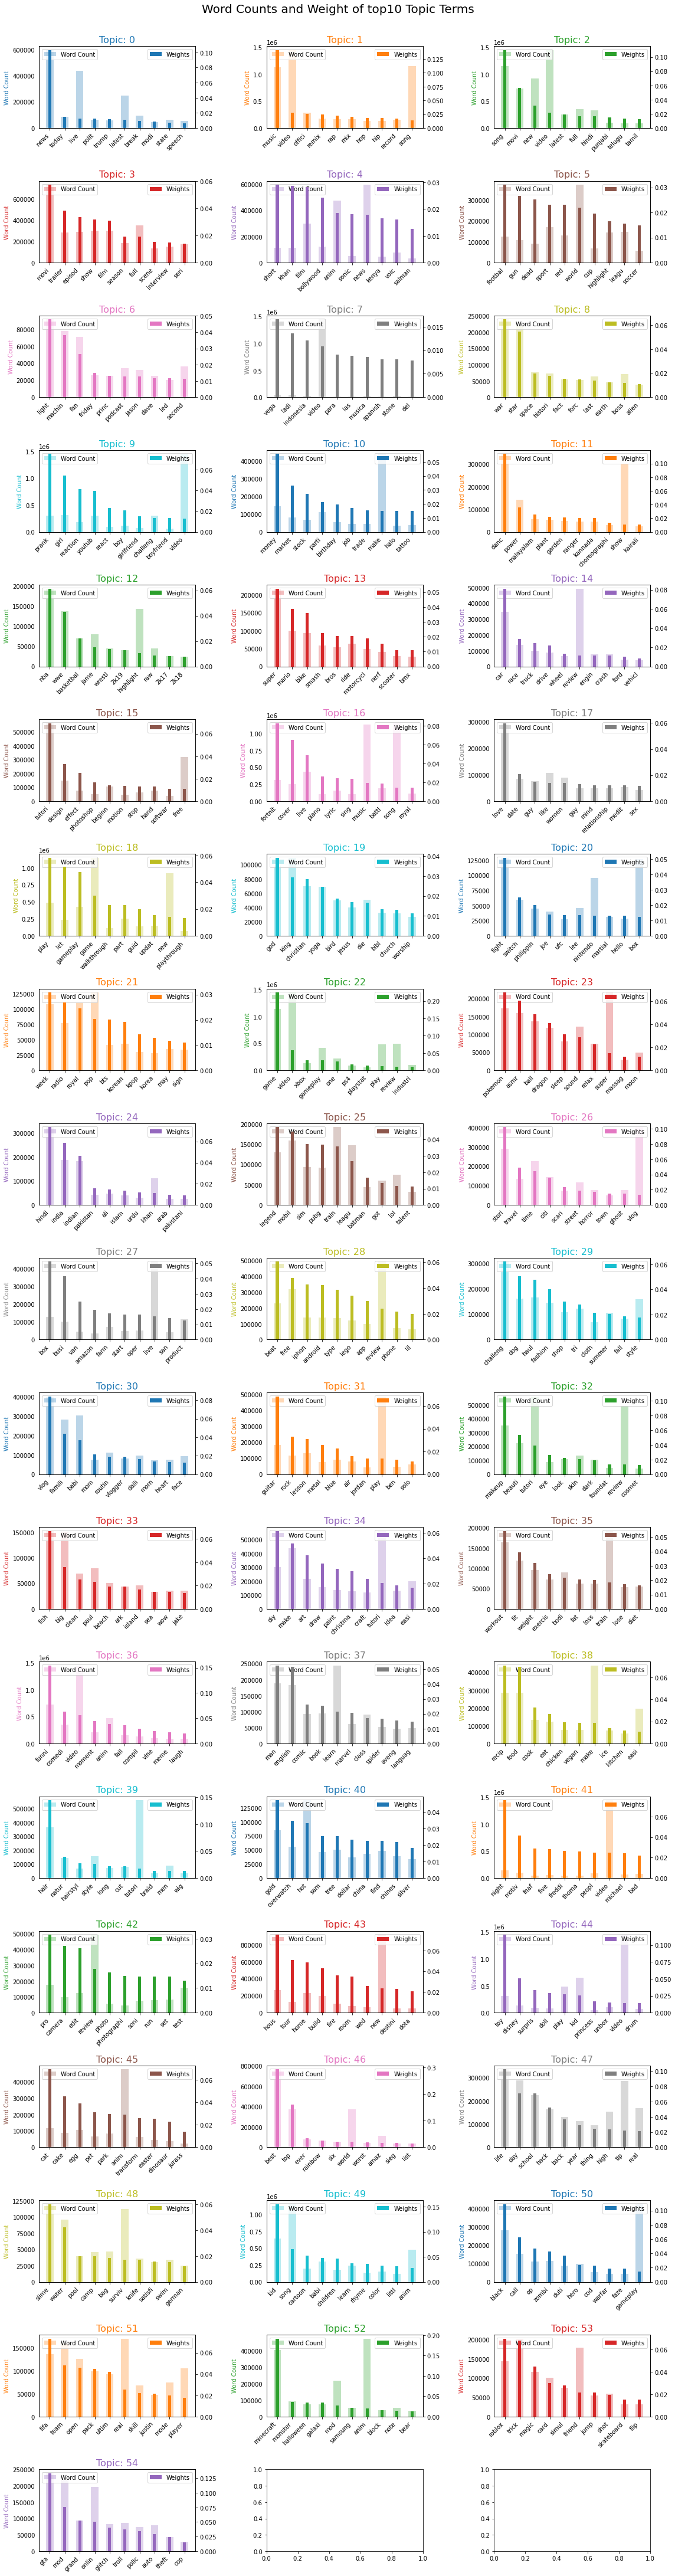

In [52]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(19, 3, figsize=(16, 60))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
n_col = len(cols)
for i, ax in enumerate(axes.flatten()):
    if i == 55:
        break
    ax.bar(x='word', height="frequency", data=df.loc[df.topic_id == i, :],
           color=cols[i % n_col], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="weight",
                data=df.loc[df.topic_id == i, :], color=cols[i % n_col], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i % n_col])
    ax.set_title('Topic: ' + str(i), color=cols[i % n_col], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
                       rotation=45, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Counts and Weight of top10 Topic Terms',
             fontsize=20, y=1.01)
plt.show()

In [53]:
fig.savefig('topic_terms.pdf')

<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipython-input-54-94ef1f2f784e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
<ipy

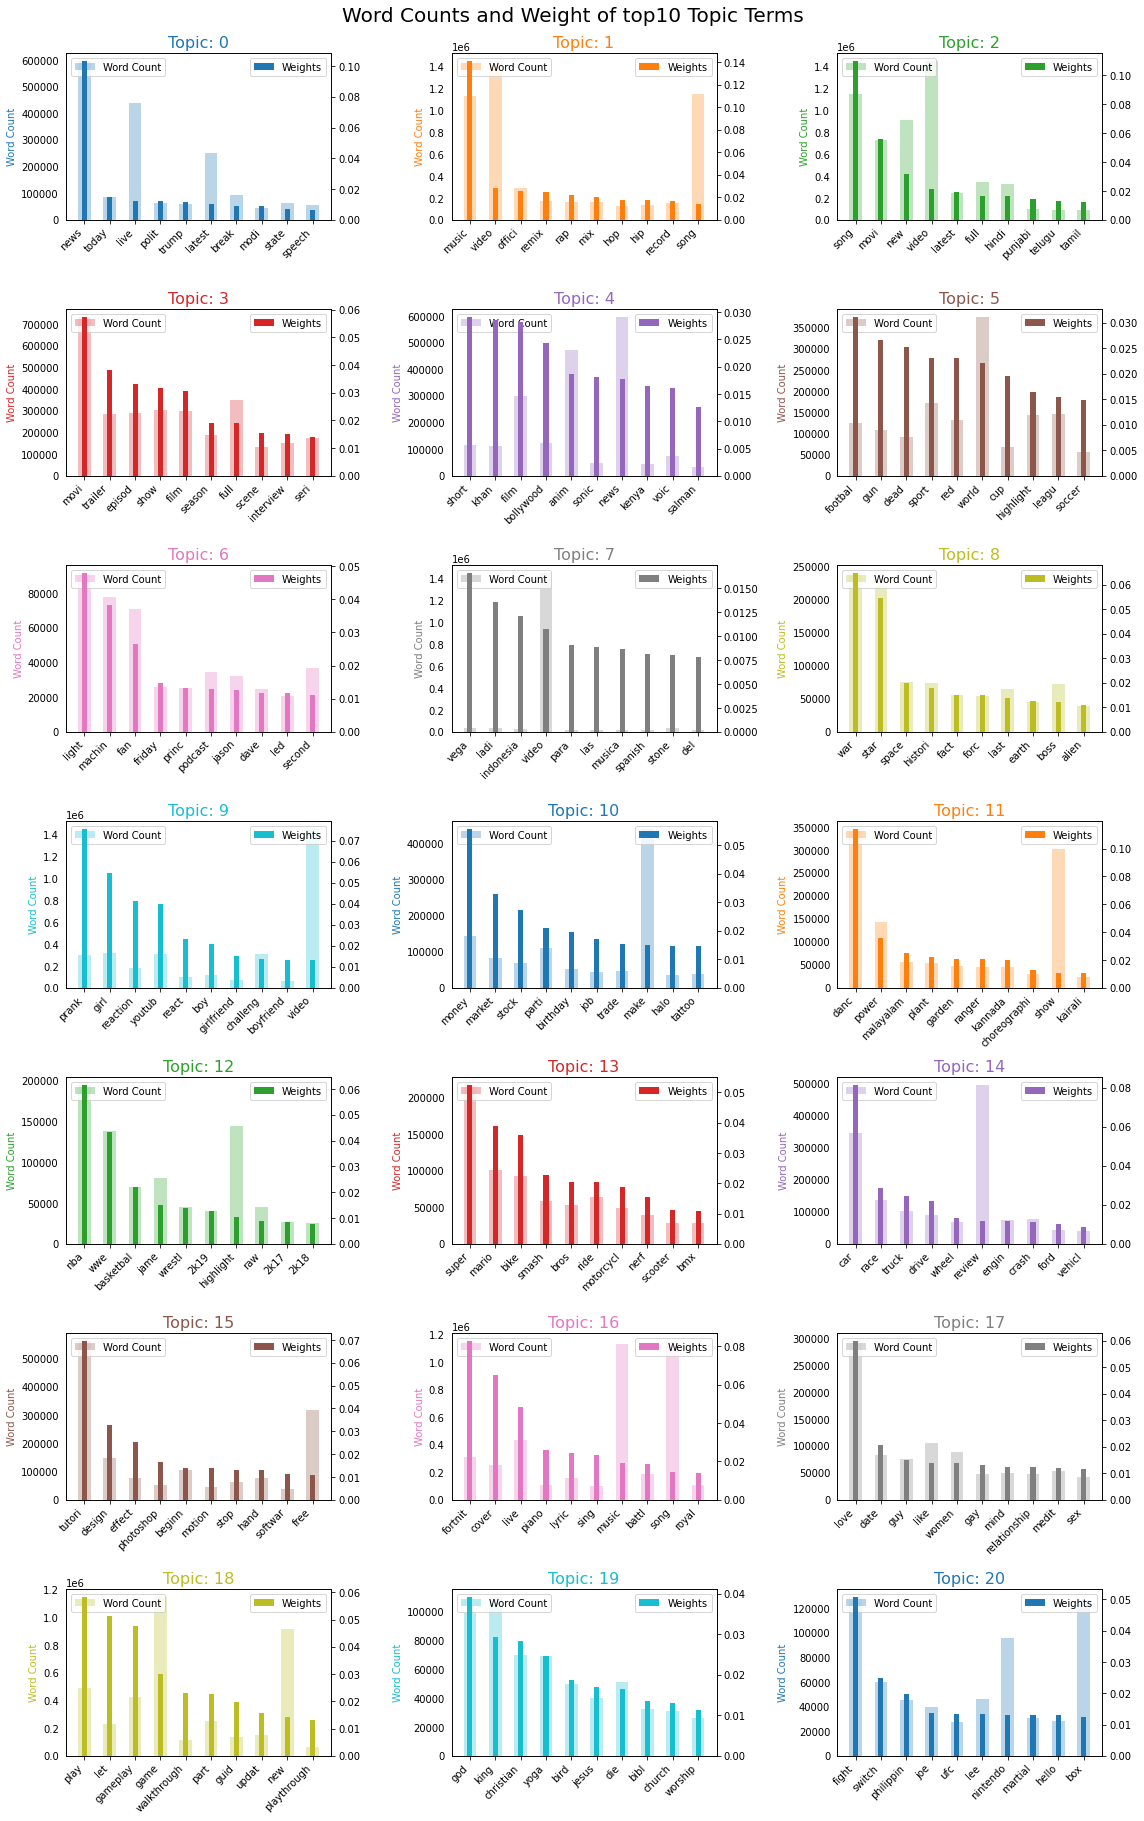

In [54]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(7, 3, figsize=(16, 25))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
n_col = len(cols)
for i, ax in enumerate(axes.flatten()):
    if i == 21:
        break
    ax.bar(x='word', height="frequency", data=df.loc[df.topic_id == i, :],
           color=cols[i % n_col], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="weight",
                data=df.loc[df.topic_id == i, :], color=cols[i % n_col], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i % n_col])
    ax.set_title('Topic: ' + str(i), color=cols[i % n_col], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'],
                       rotation=45, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Counts and Weight of top10 Topic Terms',
             fontsize=20, y=1.01)
plt.show()

In [55]:
fig.savefig('topic_terms_1.pdf')

<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
<ipython-input-58-34fab41d1531>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.top

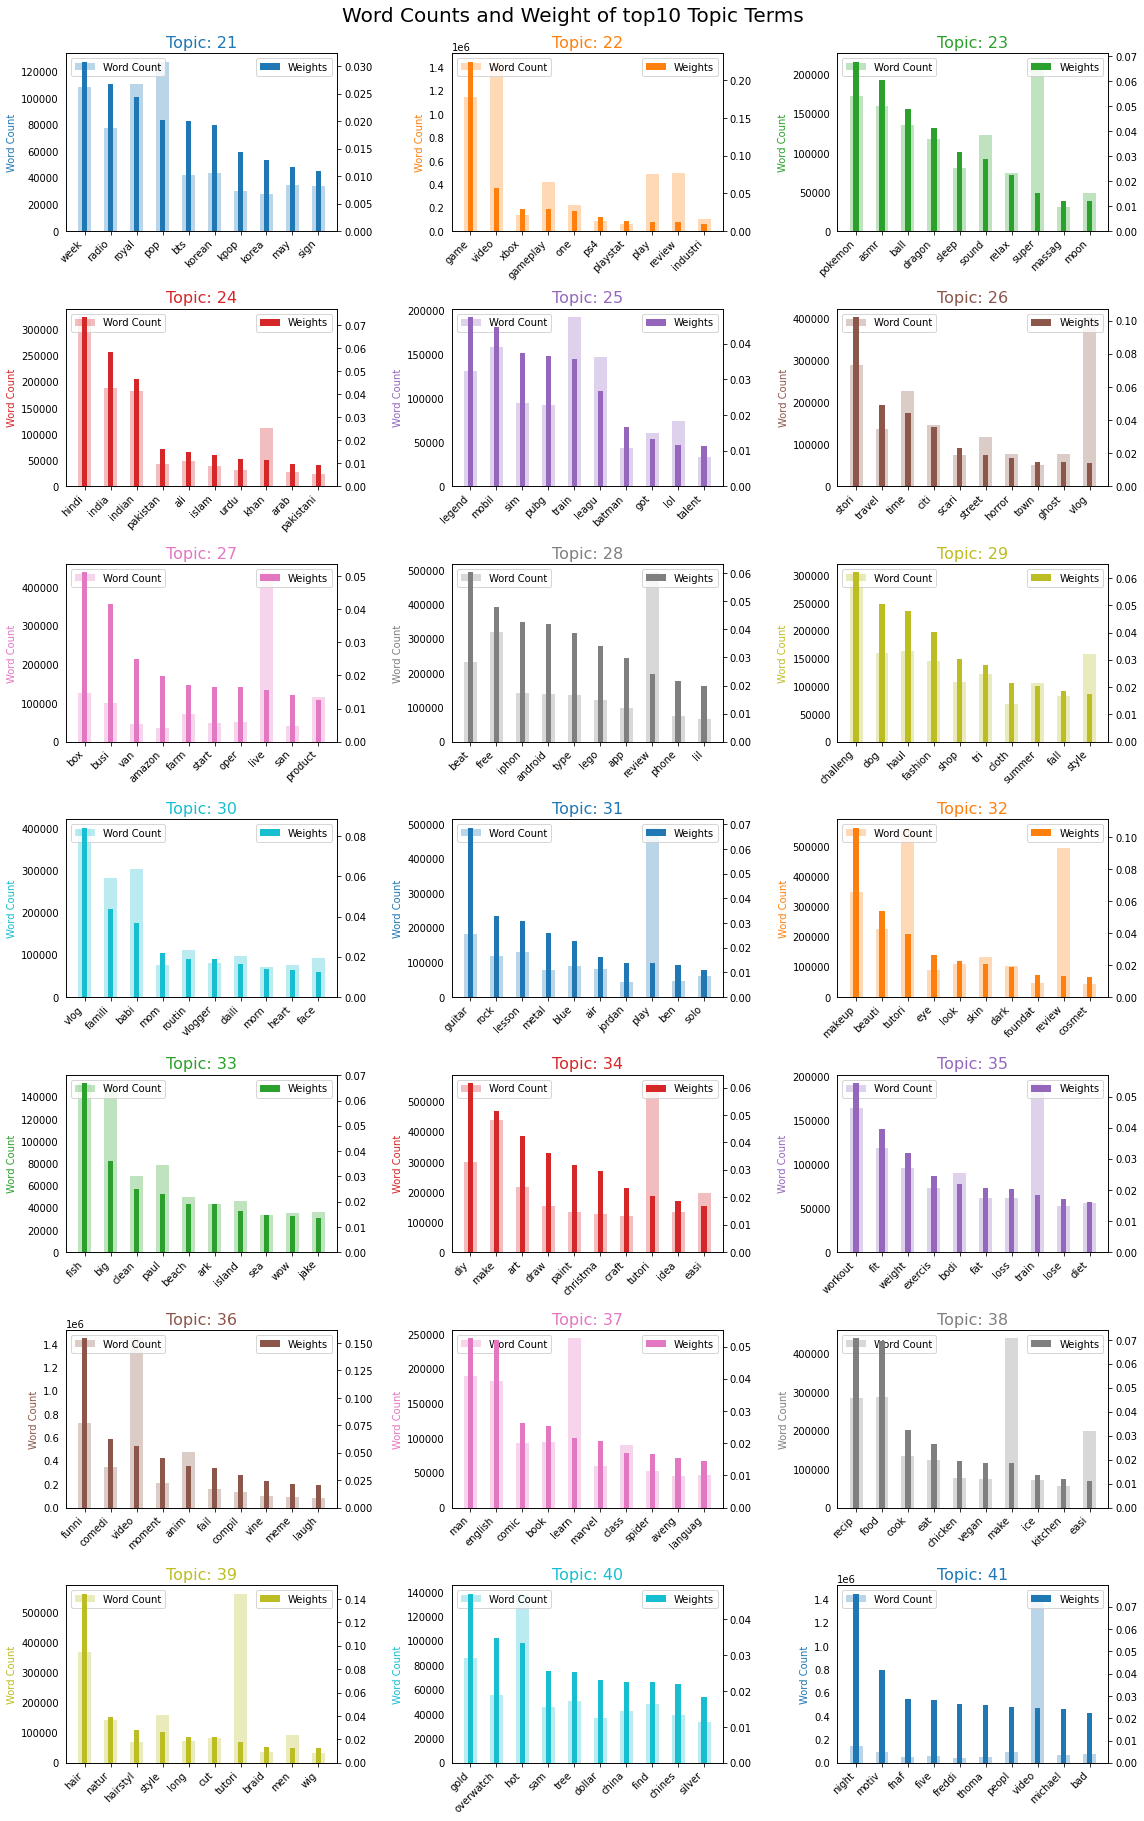

In [58]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(7, 3, figsize=(16, 25))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
n_col = len(cols)
for i, ax in enumerate(axes.flatten()):
    
    ax.bar(x='word', height="frequency", data=df.loc[df.topic_id == i + 21, :],
           color=cols[i % n_col], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="weight",
                data=df.loc[df.topic_id == i + 21, :], color=cols[i % n_col], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i % n_col])
    ax.set_title('Topic: ' + str(i + 21), color=cols[i % n_col], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i + 21, 'word'],
                       rotation=45, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Counts and Weight of top10 Topic Terms',
             fontsize=20, y=1.01)
plt.show()

In [59]:
fig.savefig('topic_terms_2.pdf')

<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
<ipython-input-61-0334decb8d36>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.top

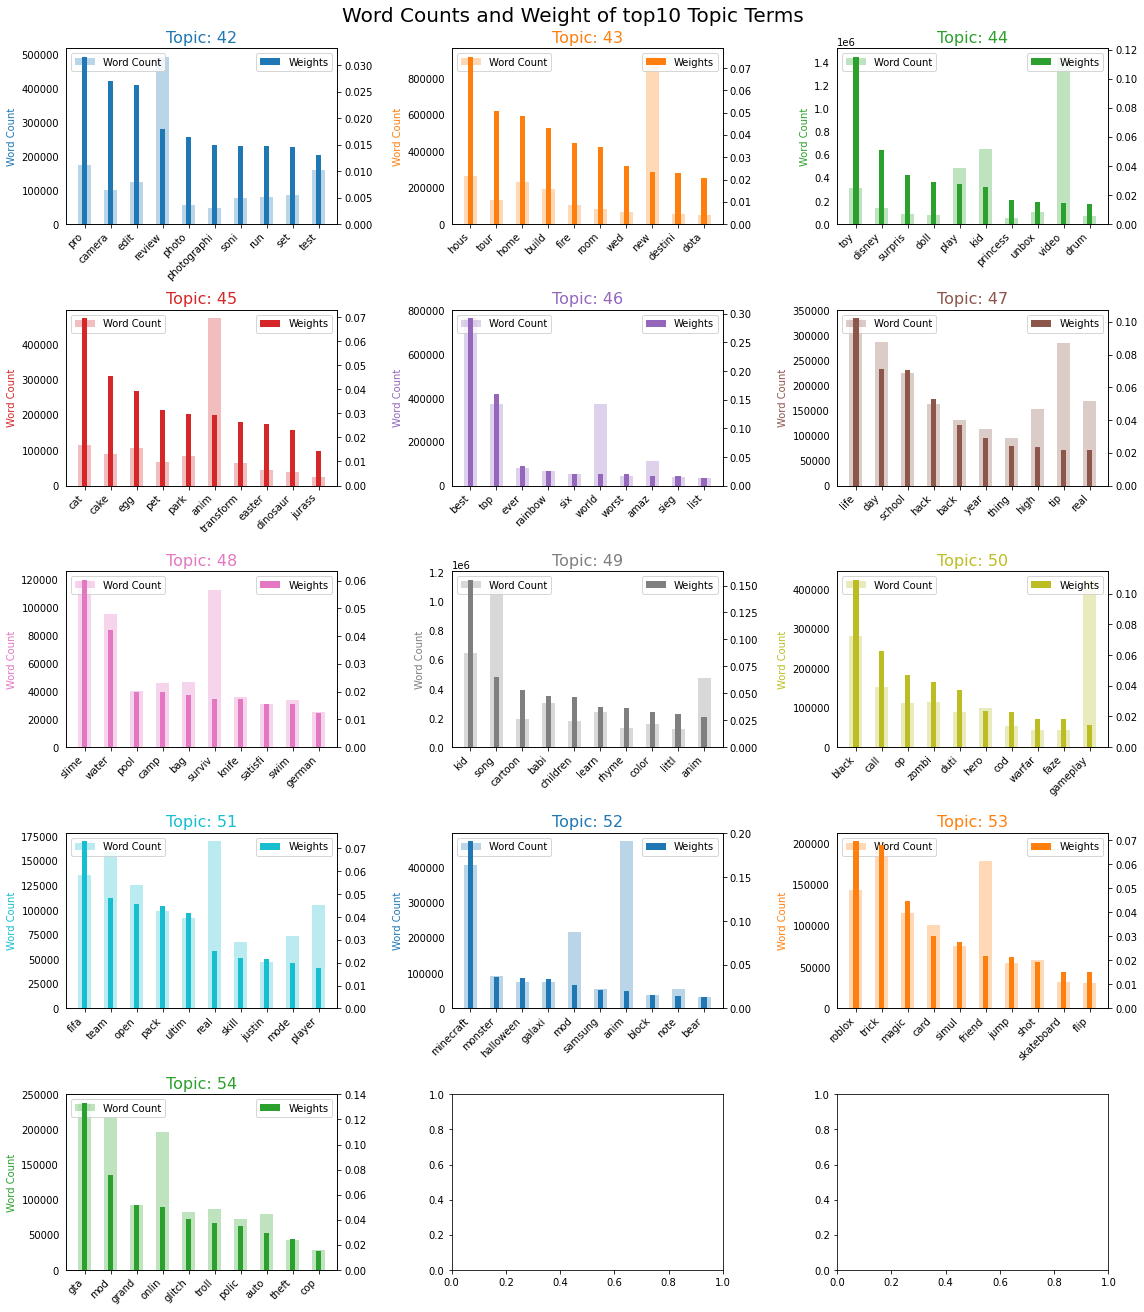

In [61]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 3, figsize=(16, 18))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
n_col = len(cols)
for i, ax in enumerate(axes.flatten()):
    
    if i >= 13:
        break
    
    ax.bar(x='word', height="frequency", data=df.loc[df.topic_id == i + 42, :],
           color=cols[i % n_col], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="weight",
                data=df.loc[df.topic_id == i + 42, :], color=cols[i % n_col], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i % n_col])
    ax.set_title('Topic: ' + str(i + 42), color=cols[i % n_col], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i + 42, 'word'],
                       rotation=45, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Counts and Weight of top10 Topic Terms',
             fontsize=20, y=1.01)
plt.show()

In [62]:
fig.savefig('topic_terms_3.pdf')